In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.4f}".format
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
plt.style.use("~/.dracula.mplstyle")
import statsmodels.api as sm

In [2]:
class DataImport:
    
    def __init__(self, filename, add_ind=[], na_method="interpolate"):
        self.xlsx = pd.ExcelFile(filename)
        self.add_ind = add_ind # Additional indices to try to 
        
        print(f"Read in <{filename}>.")
        self.sheets = []
        print('-'*20, "Reading Sheets ", '-'*20)
        self.read_sheets()
        print('-'*20, "Setting Indices", '-'*20)
        self.set_indices()
        print('-'*20, "Checking Nulls ", '-'*20)
        self.check_nulls(na_method)
        print("\n\n")
    
    def read_sheets(self):
        for i, s in enumerate(self.xlsx.sheet_names):
            read_sheet = self.xlsx.parse(s)
            print(f"Sheet {i}: {s}; shape={read_sheet.shape}")
            self.sheets.append(read_sheet)
    
    def set_indices(self):
        for s in self.sheets:
            for d in ["date", "Date", "Unnamed: 0"]+self.add_ind:
                try:
                    s.set_index(d, inplace=True) # Date as index
                    break
                except KeyError:
                    continue
    
    def check_nulls(self, method):
        n = 0
        for i, s in enumerate(self.sheets[1:]):
            has_nulls = True
            while has_nulls:
                if sum(s.isna().sum())==0: # Check for nulls
                    has_nulls = False
                else:
                    if method=="interpolate":
                        print(f"Null values found in <{i+1}>. Interpolating linearly.")
                        s = s.interpolate() # Linerly interpolate nulls
                        self.sheets[i+1] = s
                    elif method=="drop":
                        print(f"Null values found in <{i+1}>. Dropping.")
                        s = s.dropna()
                        self.sheets[i+1] = s
                    elif method=="none":
                        break
                    n += 1
                if n>i+1:
                    print("Something broke...")
                    n=i+1
                    break
        if n==0: print("No nulls found :)")

xl = DataImport("gmo.xlsx", na_method="none")
display(xl.sheets[0])
sig = xl.sheets[1]
ret = xl.sheets[2]
ret = ret.subtract(xl.sheets[3]["US3M"], axis=0)

Read in <gmo.xlsx>.
-------------------- Reading Sheets  --------------------
Sheet 0: descriptions; shape=(6, 4)
Sheet 1: signals; shape=(345, 4)
Sheet 2: returns (total); shape=(345, 3)
Sheet 3: risk-free rate; shape=(345, 2)
-------------------- Setting Indices --------------------
-------------------- Checking Nulls  --------------------
No nulls found :)





,Unit,Type,Description
Unnamed: 0,,,
DP,Ratio,Index,Dividend-Price Ratio of the S&P500
EP,Ratio,Index,Earnings-Price Ratio of the S&P500
US10Y,Yield,Index,10-Year Tnotes
SPY,Total Return,ETF,S&P 500
GMWAX,Total Return,Mutual Fund,GMO
RF,Total Return,Index,3-Month Tbills


# 2 Analyzing GMO

This section utilizes data in the file, gmo analysis data.xlsx.

Examine GMO’s performance. Use the risk-free rate to convert the total returns to excess returns

#### 1. Calculate the mean, volatility, and Sharpe ratio for GMWAX. Do this for three samples:

• from inception through 2011

• 2012-present

• inception - present

Has the mean, vol, and Sharpe changed much since the case?

The mean and Sharpe of GMO and SPY were relatively low in the period 1993-2011. From 2012-2021, the mean increased substantially with lower volatility, leading to a vastly superior Sharpe. For the entire sample of data, 

In [3]:
def pivot_summaries(data, year_mask=None, pi=0.05, nper=12):
    if not(year_mask):
        year_mask = [(str(min(data.index).year), str(max(data.index).year))]
    
    data_melt = pd.melt(data, ignore_index=False).sort_index()
    
    pivlist = []
    for start, end in year_mask:
        def me(x): return nper * np.mean(x)
        def sd(x): return np.sqrt(nper) * np.std(x, ddof=1) # account for degrees of freedom
        def sr(x): return np.sqrt(nper) * np.mean(x) / np.std(x, ddof=1)
        af = [me, sd, sr]
        af_names = ["Mean", "Vol", "Sharpe"]
        
        piv = pd.pivot_table(data_melt[start:end], index="variable", values="value",
                             aggfunc=af)
        piv.columns = pd.MultiIndex.from_arrays([[f"{start}-{end}"] * len(af), af_names],
                                                names=["year", "measure"])
        pivlist.append(piv)

    summ = pd.concat(pivlist, axis=1)
    return summ

def year_to_index(df):
    return df.T.reset_index(level="year").pivot(columns="year").T

miny = str(sig.index.min().year)
maxy = str(sig.index.max().year)

year_mask = [(miny, "2011"), ("2012", maxy), (miny, maxy)]
ps = pivot_summaries(ret, year_mask)
# ps = year_to_index(ps)
display(ps)

year     1993-2011               2012-2021               1993-2021         \
measure       Mean    Vol Sharpe      Mean    Vol Sharpe      Mean    Vol   
variable                                                                    
GMWAX       0.0158 0.1250 0.1266    0.0593 0.0853 0.6952    0.0329 0.1111   
SPY         0.0538 0.1526 0.3528    0.1545 0.1311 1.1785    0.0883 0.1461   

year             
measure  Sharpe  
variable         
GMWAX    0.2964  
SPY      0.6044

#### 2. GMO believes a risk premium is compensation for a security’s tendency to lose money at “bad times”. For all three samples, analyze extreme scenarios by looking at

• Min return

• 5th percentile (VaR-5th) • Maximum drawdown1

(a) Does GMWAX have high or low tail-risk as seen by these stats?

(b) Does that vary much across the two subsamples?

In [4]:
ret.dtypes

SPY      float64
GMWAX    float64
dtype: object

In [5]:
def tailrisk(v, prob, logret=False, exkurt=True):
    """Arguments:
    v: pd.DataFrame containing columns of returns
    prob: float percentile for VaR
    excess: bool whether kurtosis of normal = 0 (True) or = 3 (False)
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mi = v.min()
#     sk = v.skew()
#     ku = v.kurtosis() - 3 * exkurt
    var = v.quantile(prob)
    
    cvar = []
    mask =  v < v.quantile(prob)
    for name, col in mask.iteritems():
        below = v[name].loc[col]
        cvar.append(sum(below)/len(below))
    
    cvar = pd.Series(cvar, index=c)
    
    if logret:
        cumu = np.exp(v.cumsum())
    else:
        cumu = (v+1).cumprod()
    from_peak = (cumu - cumu.cummax()) / cumu.cummax()

    pl, rl, dl = [], [], []
    trough = from_peak.idxmin()
    for col, date in trough.iteritems():
        peak = max(v.loc[(from_peak.index < date) & (from_peak[col] == 0), col].index)
        try:
            reco = min(v.loc[(from_peak.index > date) & (from_peak[col] == 0), col].index)
        except ValueError:
            reco = None
        
        if logret:
            # This may not work right at the moment...
            draw = np.log(cumu.loc[date,col] / cumu.loc[peak,col])
        else:
            draw = (cumu.loc[date,col] - cumu.loc[peak,col]) / cumu.loc[peak,col]

        pl.append(peak); rl.append(reco); dl.append(draw)

    dl = pd.Series(dl, index=c)
    pl = pd.Series(pl, index=c)
    rl = pd.Series(rl, index=c)
    
    ret = pd.DataFrame([mi, var, cvar, dl],
                       index=["min", f"var_{prob}", f"cvar_{prob}", "drawdown"],
                       columns=c)
    dra = pd.DataFrame([pl, trough, rl],
                       index=["peak", "trough", "recovery"],
                       columns=c)
    ret = pd.concat([ret], axis=0).T
    
    return ret

tr = pd.DataFrame()
for y in year_mask:
    df = tailrisk(ret[y[0]:y[1]], 0.05, logret=False)
    df.columns = pd.MultiIndex.from_arrays([[f"{y[0]}-{y[1]}"] * len(df.columns), df.columns],
                                                names=["year", "measure"])
    tr = pd.concat([tr, df], axis=1)
tr

year    1993-2011                             2012-2021                     \
measure       min var_0.05 cvar_0.05 drawdown       min var_0.05 cvar_0.05   
SPY       -0.1656  -0.0783   -0.1008  -0.5600   -0.1247  -0.0602   -0.0821   
GMWAX     -0.1492  -0.0598   -0.0965  -0.4729   -0.1187  -0.0306   -0.0540   

year             1993-2021                              
measure drawdown       min var_0.05 cvar_0.05 drawdown  
SPY      -0.1963   -0.1656  -0.0696   -0.0956  -0.5600  
GMWAX    -0.1696   -0.1492  -0.0449   -0.0858  -0.4729

#### 3. For all three samples, regress excess returns of GMWAX on excess returns of SPY.

(a) Report the estimated alpha, beta, and r-squared.

(b) Is GMWAX a low-beta strategy? Has that changed since the case?

(c) Does GMWAX provide alpha? Has that changed across the subsamples?

In [6]:
def portstats_bm(v, bm, nper=12):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    bm: pd.DataFrame containing rows of returns
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    
    alpha, rsq, mae, tr, ir, reg = [], [], [], [], [], []
    beta = {}
    for col in bm.columns:
        beta[col] = []
    
    for name, col in v.iteritems():
        res = sm.OLS(col, sm.add_constant(bm.values), missing="drop").fit()
        
        alpha.append(res.params[0] * nper)
        rsq.append(res.rsquared)
        mae.append(abs(res.params[0] * nper))
        for i, col in enumerate(bm.columns):
            beta[col].append(res.params[i+1])
        tr.append(mu[name] / res.params[1])
        ir.append(res.params[0] / res.resid.std() * np.sqrt(nper))
        reg.append(res)
    
    alpha = pd.Series(alpha, index=c)
    beta = pd.DataFrame(beta, index=c).T
    beta.index = ["beta_"+i for i in beta.index]
    mae = pd.Series(mae, index=c)
    tr = pd.Series(tr, index=c)
    ir = pd.Series(ir, index=c)
    
    ret = pd.DataFrame([mu, sig, mu / sig, alpha],
                       index=["mean", "std", "sharpe", "alpha"],
                       columns=c)
    end = pd.DataFrame([rsq, mae, tr, ir], index=["r2", "mae", "treynor", "info ratio"], columns=c)
    
    ret = pd.concat([ret, beta, end]).T
    return ret, reg

re = pd.DataFrame()
for y in year_mask:
    tdf = ret[y[0]:y[1]]
    rdf, reg = portstats_bm(tdf[["GMWAX"]], tdf[["SPY"]])
    rdf = rdf[["alpha", "beta_SPY", "r2"]]
    rdf.columns = pd.MultiIndex.from_arrays([[f"{y[0]}-{y[1]}"] * len(rdf.columns), rdf.columns],
                                                names=["year", "measure"])
    re = pd.concat([re, rdf], axis=1)
re

year    1993-2011                 2012-2021                 1993-2021  \
measure     alpha beta_SPY     r2     alpha beta_SPY     r2     alpha   
GMWAX     -0.0058   0.5396 0.5071   -0.0285   0.5683 0.7633   -0.0135   

year                     
measure beta_SPY     r2  
GMWAX     0.5461 0.5668

# 3 Forecast Regressions

This section utilizes data in the file, gmo analysis data.xlsx.

#### 1. Consider the lagged regression, where the regressor, (X,) is a period behind the target, (rSPY ).

rSPY =αSPY,X +(βSPY,X)′X +εSPY,X (1) t t−1 t

Estimate (1) and report the R2, as well as the OLS estimates for α and β. Do this for...

• X as a single regressor, the dividend-price ratio.

• X as a single regressor, the earnings-price ratio.

• X as three regressors, the dividend-price ratio, the earnings-price ratio, and the 10-year yield.

For each, report the r-squared.

In [7]:
ret = xl.sheets[2] # reset to total returns
regdat = pd.concat([ret[["SPY"]], sig.shift(1)], axis=1).dropna()

stats, regs = [], []
a, b = portstats_bm(regdat[["SPY"]], regdat[["DP"]])
stats.append(a)
regs.append(b)
stats[-1]

,mean,std,sharpe,alpha,beta_DP,r2,mae,treynor,info ratio
SPY,0.1114,0.1462,0.7620,-0.0709,0.0079,0.0068,0.0709,14.1065,-0.4868


In [8]:
a, b = portstats_bm(regdat[["SPY"]], regdat[["EP"]])
stats.append(a)
regs.append(b)
stats[-1]

,mean,std,sharpe,alpha,beta_EP,r2,mae,treynor,info ratio
SPY,0.1114,0.1462,0.7620,-0.0488,0.0029,0.0078,0.0488,37.9841,-0.3349


In [9]:
a, b = portstats_bm(regdat[["SPY"]], regdat[["DP", "EP", "US10Y"]])
stats.append(a)
regs.append(b)
stats[-1]

,mean,std,sharpe,alpha,beta_DP,beta_EP,beta_US10Y,r2,mae,treynor,info ratio
SPY,0.1114,0.1462,0.7620,-0.1135,0.0064,0.0025,-0.0013,0.0150,0.1135,17.3484,-0.7823


#### 2. For each of the three regressions, let’s try to utilize the resulting forecast in a trading strategy.
SPY
Xt to forecast the (t + 1) return.

• Set the scale of the investment in SPY equal to 100 times the forecasted value:

We are not taking this scaling too seriously. We just want the strategy to go bigger in periods where the forecast is high and to withdraw in periods where the forecast is low, or even negative.

• Calculate the return on this strategy:

rx = w rSPY t+1 t t+1

You should now have the trading strategy returns, rx for each of the forecasts. For each strategy, estimate

• mean, volatility, Sharpe, • max-drawdown

• market alpha

• market beta

• market Information ratio

In [10]:
def portstats_bm(v, bm, nper=12, logret=False):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    bm: pd.DataFrame containing rows of returns
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    
    alpha, rsq, mae, tr, ir, reg = [], [], [], [], [], []
    beta = {}
    for col in bm.columns:
        beta[col] = []
    
    for name, col in v.iteritems():
        res = sm.OLS(col, sm.add_constant(bm.values), missing="drop").fit()
        
        alpha.append(res.params[0] * nper)
        rsq.append(res.rsquared)
        mae.append(abs(res.params[0] * nper))
        for i, col in enumerate(bm.columns):
            beta[col].append(res.params[i+1])
        tr.append(mu[name] / res.params[1])
        ir.append(res.params[0] / res.resid.std() * np.sqrt(nper))
        reg.append(res)
    
    alpha = pd.Series(alpha, index=c)
    beta = pd.DataFrame(beta, index=c).T
    beta.index = ["beta_"+i for i in beta.index]
    mae = pd.Series(mae, index=c)
    tr = pd.Series(tr, index=c)
    ir = pd.Series(ir, index=c)
    
    if logret:
        cumu = np.exp(v.cumsum())
    else:
        cumu = (v+1).cumprod()
    from_peak = (cumu - cumu.cummax()) / cumu.cummax()

    pl, rl, dl = [], [], []
    trough = from_peak.idxmin()
    for col, date in trough.iteritems():
        pk = v.loc[(from_peak.index < date) & (from_peak[col] == 0), col].index
        if len(pk):
            peak = max(pk)
        else:
            peak = max(v.index)
            date = peak
        
        try:
            reco = min(v.loc[(from_peak.index > date) & (from_peak[col] == 0), col].index)
        except ValueError:
            reco = None
        
        if logret:
            # This may not work right at the moment...
            draw = np.log(cumu.loc[date,col] / cumu.loc[peak,col])
        else:
            draw = (cumu.loc[date,col] - cumu.loc[peak,col]) / cumu.loc[peak,col]

        pl.append(peak); rl.append(reco); dl.append(draw)

    dl = pd.Series(dl, index=c)
    pl = pd.Series(pl, index=c)
    rl = pd.Series(rl, index=c)
    
    ret = pd.DataFrame([mu, sig, mu / sig, alpha],
                       index=["mean", "std", "sharpe", "alpha"],
                       columns=c)
    end = pd.DataFrame([rsq, mae, tr, ir, dl], index=["r2", "mae", "treynor", "info ratio", "drawdown"], columns=c)
    dra = pd.DataFrame([pl, trough, rl],
                       index=["peak", "trough", "recovery"],
                       columns=c)
    ret = pd.concat([ret, beta, end, dra]).T
    return ret, reg

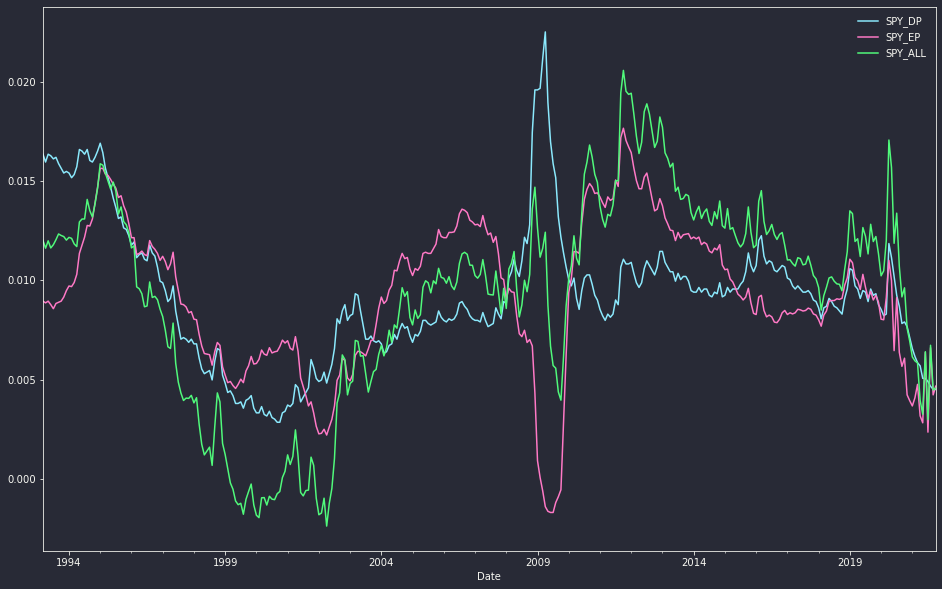

In [11]:
pred = pd.DataFrame({
    "SPY_DP": regs[0][0].predict(sm.add_constant(regdat[["DP"]].values)),
    "SPY_EP": regs[1][0].predict(sm.add_constant(regdat[["EP"]].values)),
    "SPY_ALL": regs[2][0].predict(sm.add_constant(regdat[["DP", "EP", "US10Y"]].values))
}, index=regdat.index).dropna()

pred.plot()
plt.show()

In [12]:
strat = (100*pred).multiply(ret["SPY"], axis=0).dropna()
a, b = portstats_bm(strat, regdat[["SPY"]])
a#[["mean", "std", "sharpe", "drawdown", "alpha", "beta_SPY", "info ratio"]]

,mean,std,sharpe,alpha,beta_SPY,r2,mae,treynor,info ratio,drawdown,peak,trough,recovery
SPY_DP,0.1180,0.1511,0.7809,0.0132,0.9407,0.8288,0.0132,0.1254,0.2107,-0.6415,2007-10-31,2009-02-28,2012-03-31
SPY_EP,0.1200,0.1321,0.9081,0.0311,0.7980,0.7798,0.0311,0.1503,0.5012,-0.3850,2007-10-31,2010-06-30,2012-03-31
SPY_ALL,0.1354,0.1499,0.9032,0.0408,0.8491,0.6855,0.0408,0.1595,0.4856,-0.5193,2007-10-31,2009-02-28,2011-04-30


#### 3. GMO believes a risk premium is compensation for a security’s tendency to lose money at “bad
times”. Let’s consider risk characteristics.

(a) For both strategies, the market, and GMO, calculate the monthly VaR for π = .05. Just use the quantile of the historic data for this VaR calculation.

(b) The GMO case mentions that stocks under-performed short-term bonds from 2000-2011. Does the dynamic portfolio above under-perform the risk-free rate over this time?

(c) Based on the regression estimates, in how many periods do we estimate a negative risk premium?

(d) Do you believe the dynamic strategy takes on extra risk??

In [13]:
tailrisk(ret[["GMWAX"]].dropna(), prob=0.05)

,min,var_0.05,cvar_0.05,drawdown
GMWAX,-0.1450,-0.0444,-0.0831,-0.3552


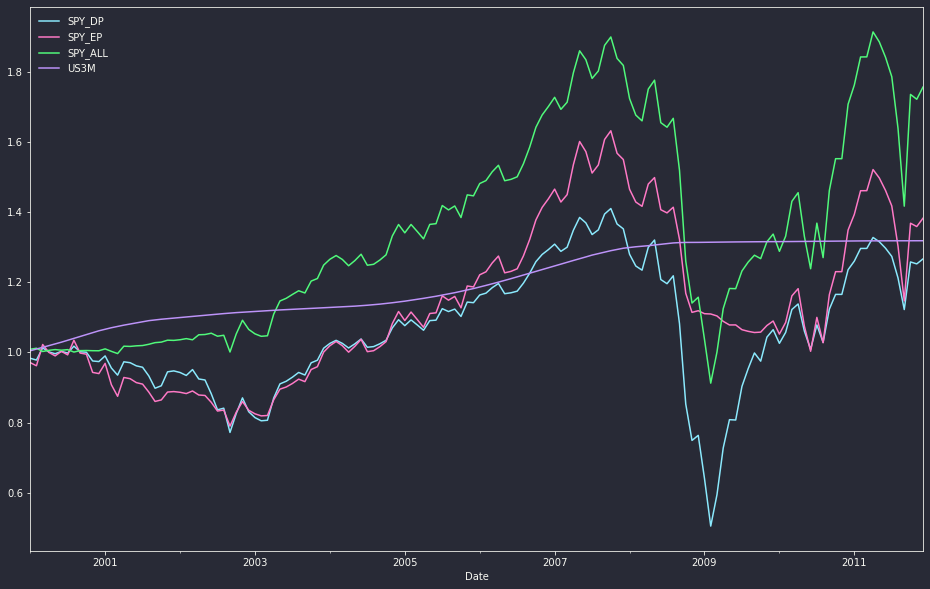

In [14]:
fig, ax = plt.subplots()

(1+strat["2000":"2011"]).cumprod().plot(ax=ax)
(1+xl.sheets[3]["2000":"2011"]).cumprod().plot(ax=ax)
plt.show()

# 4 Out-of-Sample Forecasting
This section utilizes data in the file, gmo analysis data.xlsx.
Reconsider the problem above, of estimating (1) for x. The reported R2 was the in-sample R2–it examined how well the forecasts fit in the sample from which the parameters were estimated.
This time, only consider the case where we are regressing on the earnings-price ratio.
Let’s consider the out-of-sample r-squared. To do so, we need to do the following:

• Startatt=60.

• Estimate (1) only using data through time t.

• Use the estimated parameters of (1), along with xt+1 to calculate the out-of-sample forecast for
the following period, t + 1.

• Calculate the t + 1 forecast error,

t+1 t+1 t+1 • Move to t = 61, and loop through the rest of the sample.

You now have the time-series of out-of-sample prediction errors, ex.

Calculate the time-series of out-of-sample prediction errors e0, which are based on the null forecast:

#### 1. Report the out-of-sample R2 :

SPY SPY,x SPY,x ′
rˆ =αˆ +(β )x
t+1t t
x SPY SPY e =r −rˆ
1 􏰃t
SPY SPY
r ̄ = r t+1 t i
i=1
0 SPY SPY e =r −r ̄
t+1 t+1 t+1
2 􏰂Ti=61 (exi )2 ROOS ≡ 1−􏰂T 􏰀e0􏰁2
 i=61 i

Note that unlike an in-sample r-squared, the out-of-sample r-squared can be anywhere between
(−∞, 1].

Did this forecasting strategy produce a positive OOS r-squared?

In [15]:
window = 60
sto = [[],[],[]]
for i in range(len(regdat)-window-1):
    slice = regdat[i:i+window]
    Y = slice["SPY"]
    
    for j, p in enumerate([["DP"], ["EP"], ["DP", "EP", "US10Y"]]):
        X = sm.add_constant(slice[p])
        res = sm.OLS(Y, X).fit()
        ppp = sm.add_constant(regdat[p]).iloc[i+window:i+window+1]
#         print(ppp)
        p = res.predict(ppp).values
        sto[j].append(p[0])

rol_pred = pd.DataFrame(np.array(sto).T, index=regdat.index[window+1:], columns=["DP", "EP", "ALL"])

/Users/plee/miniconda3/envs/finmath/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


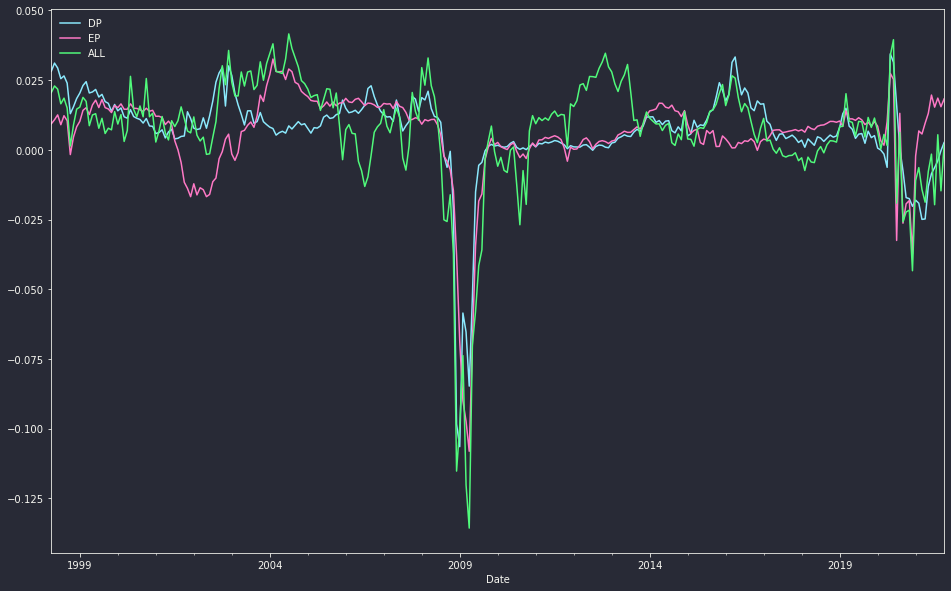

In [16]:
rol_pred.plot()
plt.show()

In [17]:
def oos_rsq(pred, act):
    """Arguments:
    pred: pd.DataFrame
    act: pd.DataFrame
    """
    epsilon_x = pred.subtract(act, axis=0)
    epsilon_0 = act - act.mean()
    return 1 - (epsilon_x ** 2).sum() / (epsilon_0 **2).sum()

rsq_oos = oos_rsq(rol_pred, regdat.iloc[window+1:]["SPY"])
rsq_oos

DP    -0.1425
EP    -0.1362
ALL   -0.2697
dtype: float64

#### 2. Re-do problem 3.2 using this OOS forecast.
How much better/worse is the OOS Earnings-Price ratio strategy compared to the in-sample version of 3.2?

In [18]:
a, b = portstats_bm(rol_pred, regdat.iloc[window+1:][["SPY"]])
a[["mean", "std", "sharpe", "drawdown", "alpha", "beta_SPY", "info ratio"]]

,mean,std,sharpe,drawdown,alpha,beta_SPY,info ratio
DP,0.0820,0.0553,1.4842,-0.4187,0.0825,-0.0055,1.4934
EP,0.0694,0.0570,1.2190,-0.4475,0.0692,0.0024,1.2153
ALL,0.0831,0.0760,1.0928,-0.6241,0.0840,-0.0107,1.1058


#### 3. Re-do problem 3.3 using this OOS forecast.
Is the point-in-time version of the strategy riskier?

In [19]:
merge = pd.concat([rol_pred, regdat.iloc[window+1:]], axis=1)
tailrisk(ret[["GMWAX"]], prob=0.05)

,min,var_0.05,cvar_0.05,drawdown
GMWAX,-0.1450,-0.0444,-0.0831,-0.3552
